<a href="https://colab.research.google.com/github/ol287/my-fakenews-model/blob/main/My_fakenews_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import essential libraries for data processing, machine learning, and neural network development

# General-purpose libraries
import numpy as np  # For linear algebra operations, handling arrays, and performing mathematical operations
import pandas as pd  # For data manipulation, analysis, and handling CSV files (e.g., pd.read_csv)

# System and file handling libraries
import os  # Provides functions to interact with the operating system (e.g., file/directory operations)
import urllib.request  # For fetching data from URLs, such as downloading images or datasets
import sys  # For accessing system-specific parameters and functions

# Machine learning utilities
import sklearn  # A machine learning library offering tools for data preprocessing, model evaluation, etc.
from sklearn.model_selection import train_test_split  # For splitting datasets into training and testing subsets

# PyTorch libraries for deep learning
import torch  # The core PyTorch library for building and training neural networks
import torch.nn as nn  # Provides tools to define and implement neural network layers and architectures
from torch.utils.data import Dataset, DataLoader  # Utilities for dataset representation and data loading
import torch.nn.functional as f  # Contains functions for defining activation functions, loss functions, etc.
import torch.optim as optim  # For optimization algorithms like SGD, Adam, etc.

# Torchvision for computer vision tasks
import torchvision  # A library for computer vision, includes pre-trained models and utilities
from torchvision.transforms import v2  # Provides tools for data augmentation and preprocessing (new version)
from torchvision import models  # Contains pre-trained models for transfer learning
from torchvision.models import resnet50, ResNet50_Weights  # Specific imports for ResNet-50 model and its weights

# Learning rate scheduling
import torch.optim.lr_scheduler as lr_scheduler  # Tools to adjust learning rates during training

# Additional utilities
import random  # For generating random numbers and performing random operations (e.g., shuffling data)
from PIL import Image  # For opening, manipulating, and saving image files
import matplotlib.pyplot as plt  # A plotting library for visualizing data and results

# Importing tools for running and managing threads.
from concurrent.futures import ThreadPoolExecutor, as_completed

# Import the compute_class_weight function to handle class imbalance
from sklearn.utils.class_weight import compute_class_weight

# Import precision_score and recall_score metrics from sklearn for evaluation
from sklearn.metrics import precision_score, recall_score



In [2]:
# Check if CUDA (GPU support) is available; use GPU if possible, otherwise fall back to CPU
if torch.cuda.is_available():
    device = torch.device('cuda')  # Set device to GPU
    print("CUDA is available. Using GPU.")  # Notify user of GPU usage
else:
    device = torch.device('cpu')  # Set device to CPU
    print("CUDA is not available. Using CPU.")  # Notify user of CPU usage


CUDA is not available. Using CPU.


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Importing the Fakeddit Train Dataset**

In [4]:
# Load the dataset from a CSV file
# The file is read using pandas with the columns separated by commas (',').
df = pd.read_csv('/content/multimodal_train.csv', sep=',')


In [5]:

# Display the size of the dataset
df.shape

(564000, 16)

In [6]:
# Display the first 5 rows of the DataFrame to get a quick overview of the data.
df.head()


,author,clean_title,created_utc,domain,hasImage,id,image_url,linked_submission_id,num_comments,score,subreddit,title,upvote_ratio,2_way_label,3_way_label,6_way_label
0,Alexithymia,my walgreens offbrand mucinex was engraved wit...,1.551641e+09,i.imgur.com,True,awxhir,https://external-preview.redd.it/WylDbZrnbvZdB...,NaN,2.0,12,mildlyinteresting,My Walgreens offbrand Mucinex was engraved wit...,0.84,1,0,0
1,VIDCAs17,this concerned sink with a tiny hat,1.534727e+09,i.redd.it,True,98pbid,https://preview.redd.it/wsfx0gp0f5h11.jpg?widt...,NaN,2.0,119,pareidolia,This concerned sink with a tiny hat,0.99,0,2,2
2,prometheus1123,hackers leak emails from uae ambassador to us,1.496511e+09,aljazeera.com,True,6f2cy5,https://external-preview.redd.it/6fNhdbc6K1vFA...,NaN,1.0,44,neutralnews,Hackers leak emails from UAE ambassador to US,0.92,1,0,0
3,NaN,puppy taking in the view,1.471341e+09,i.imgur.com,True,4xypkv,https://external-preview.redd.it/HLtVNhTR6wtYt...,NaN,26.0,250,photoshopbattles,PsBattle: Puppy taking in the view,0.95,1,0,0
4,3rikR3ith,i found a face in my sheet music too,1.525318e+09,i.redd.it,True,8gnet9,https://preview.redd.it/ri7ut2wn8kv01.jpg?widt...,NaN,2.0,13,pareidolia,I found a face in my sheet music too!,0.84,0,2,2


# **Data Cleansing**

In [7]:
# Convert the 'created_utc' column from Unix timestamp to datetime format
df['created_utc'] = pd.to_datetime(df['created_utc'], unit='s')


# Display the first 5 rows to verify the change
df.head()




,author,clean_title,created_utc,domain,hasImage,id,image_url,linked_submission_id,num_comments,score,subreddit,title,upvote_ratio,2_way_label,3_way_label,6_way_label
0,Alexithymia,my walgreens offbrand mucinex was engraved wit...,2019-03-03 19:27:24,i.imgur.com,True,awxhir,https://external-preview.redd.it/WylDbZrnbvZdB...,NaN,2.0,12,mildlyinteresting,My Walgreens offbrand Mucinex was engraved wit...,0.84,1,0,0
1,VIDCAs17,this concerned sink with a tiny hat,2018-08-20 01:10:13,i.redd.it,True,98pbid,https://preview.redd.it/wsfx0gp0f5h11.jpg?widt...,NaN,2.0,119,pareidolia,This concerned sink with a tiny hat,0.99,0,2,2
2,prometheus1123,hackers leak emails from uae ambassador to us,2017-06-03 17:26:38,aljazeera.com,True,6f2cy5,https://external-preview.redd.it/6fNhdbc6K1vFA...,NaN,1.0,44,neutralnews,Hackers leak emails from UAE ambassador to US,0.92,1,0,0
3,NaN,puppy taking in the view,2016-08-16 09:51:30,i.imgur.com,True,4xypkv,https://external-preview.redd.it/HLtVNhTR6wtYt...,NaN,26.0,250,photoshopbattles,PsBattle: Puppy taking in the view,0.95,1,0,0
4,3rikR3ith,i found a face in my sheet music too,2018-05-03 03:30:18,i.redd.it,True,8gnet9,https://preview.redd.it/ri7ut2wn8kv01.jpg?widt...,NaN,2.0,13,pareidolia,I found a face in my sheet music too!,0.84,0,2,2


In [8]:
# Drop the specified columns from the DataFrame only if they exist
# Remove the columns for "2-way" and "3-way" classification
# Remove the column "title" since we already have the "clean_title" column
columns_to_drop = ['2_way_label', '3_way_label', 'author', 'title', 'linked_submission_id']

# Retain only the columns that are present in the DataFrame
existing_columns_to_drop = [col for col in columns_to_drop if col in df.columns]

# Drop the columns that exist in the DataFrame
df = df.drop(columns=existing_columns_to_drop, axis=1)

# Display the remaining columns to confirm the changes
print(df.columns)


Index(['clean_title', 'created_utc', 'domain', 'hasImage', 'id', 'image_url',
       'num_comments', 'score', 'subreddit', 'upvote_ratio', '6_way_label'],
      dtype='object')


In [9]:
# Print the number of rows before filtering
print(f"Number of rows before filtering: {len(df)}")

# Remove rows where 'hasImage' is False or 'image_url' is empty or 'clean_title' is empty
df = df[(df['hasImage'] == True) & (df['image_url'].notna()) & (df['clean_title'].notna())]

# Print the number of rows after filtering
print(f"Number of rows after filtering: {len(df)}")


Number of rows before filtering: 564000
Number of rows after filtering: 562466


In [10]:
# Replace empty (NaN) values in the 'num_comments' column with zero
df['num_comments'] = df['num_comments'].fillna(0)

<ipython-input-10-b0875f569ac7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['num_comments'] = df['num_comments'].fillna(0)


In [11]:
# Perform frequency encoding on the 'subreddit' column
freq_encoding = df['subreddit'].value_counts(normalize=True)

# Create a new column with the frequency encoding values
df['subreddit_encoded'] = df['subreddit'].map(freq_encoding)

df.head()

,clean_title,created_utc,domain,hasImage,id,image_url,num_comments,score,subreddit,upvote_ratio,6_way_label,subreddit_encoded
0,my walgreens offbrand mucinex was engraved wit...,2019-03-03 19:27:24,i.imgur.com,True,awxhir,https://external-preview.redd.it/WylDbZrnbvZdB...,2.0,12,mildlyinteresting,0.84,0,0.152294
1,this concerned sink with a tiny hat,2018-08-20 01:10:13,i.redd.it,True,98pbid,https://preview.redd.it/wsfx0gp0f5h11.jpg?widt...,2.0,119,pareidolia,0.99,2,0.083957
2,hackers leak emails from uae ambassador to us,2017-06-03 17:26:38,aljazeera.com,True,6f2cy5,https://external-preview.redd.it/6fNhdbc6K1vFA...,1.0,44,neutralnews,0.92,0,0.012868
3,puppy taking in the view,2016-08-16 09:51:30,i.imgur.com,True,4xypkv,https://external-preview.redd.it/HLtVNhTR6wtYt...,26.0,250,photoshopbattles,0.95,0,0.097965
4,i found a face in my sheet music too,2018-05-03 03:30:18,i.redd.it,True,8gnet9,https://preview.redd.it/ri7ut2wn8kv01.jpg?widt...,2.0,13,pareidolia,0.84,2,0.083957


In [12]:
# Print the number of rows before filtering
print(f"Number of rows before filtering: {len(df)}")

# Remove duplicate rows based on the 'clean_title' column, keeping the first occurrence
df = df.drop_duplicates(subset=['clean_title'], keep='first').reset_index(drop=True)

# Print the number of rows after filtering
print(f"Number of rows after filtering: {len(df)}")

df.reset_index(drop=True, inplace=True)

Number of rows before filtering: 562466
Number of rows after filtering: 501123


# **Data Visualisation**





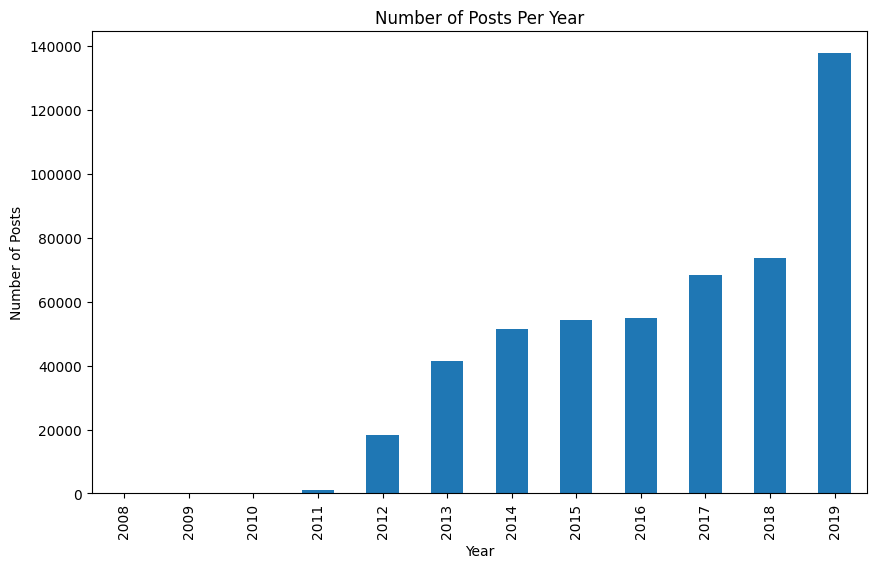

In [13]:
# Extract the year from 'created_utc' and create a new column 'created_year'
df['created_year'] = df['created_utc'].dt.year

# Plot the number of posts per year
plt.figure(figsize=(10, 6))
df.groupby('created_year').size().plot(kind='bar')
plt.title('Number of Posts Per Year')
plt.xlabel('Year')
plt.ylabel('Number of Posts')
plt.show()

**Plot the 6- Way Class Distribution of dataset:**
- 0: TRUE
- 1: SATIRE
- 2: FALSE CONNECTION
- 3: IMPOSTER CONTENT
- 4: MANIPULATED CONTENT
- 5: MISLEADING CONTENT

<Axes: title={'center': '6_way_label'}, ylabel='Frequency'>

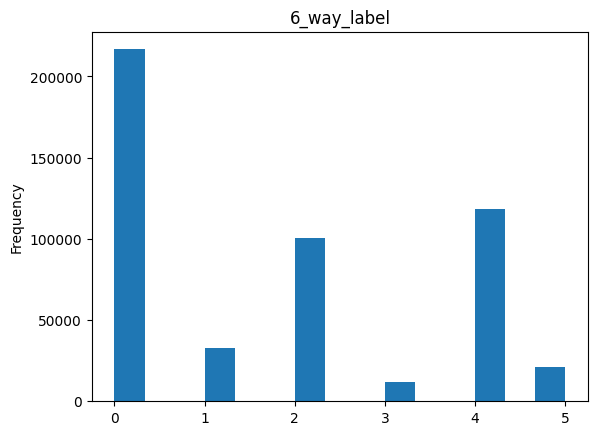

In [14]:
# Plot a histogram for the column '6_way_label'
# - kind="hist": Specifies that the plot type is a histogram
# - bins=15: Divides the data into 15 intervals (bins) for the histogram
# - title="6_way_label": Sets the title of the histogram to "6_way_label"
# Based on the class distribution graph above, the classes are not represented equally in the dataset.
df["6_way_label"].plot(kind="hist", bins=15, title="6_way_label")


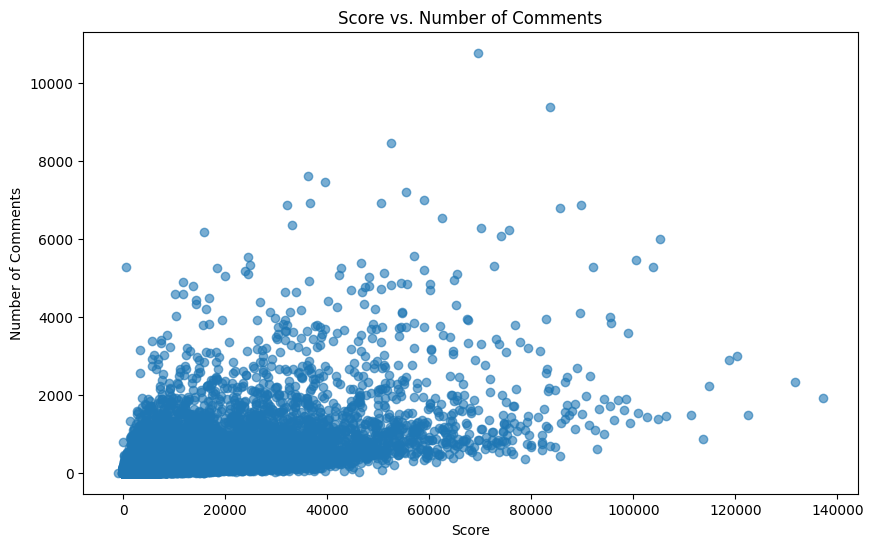

In [15]:

# Visualization : Score vs. Number of Comments
plt.figure(figsize=(10, 6))
plt.scatter(df['score'], df['num_comments'], alpha=0.6)
plt.title('Score vs. Number of Comments')
plt.xlabel('Score')
plt.ylabel('Number of Comments')
plt.show()

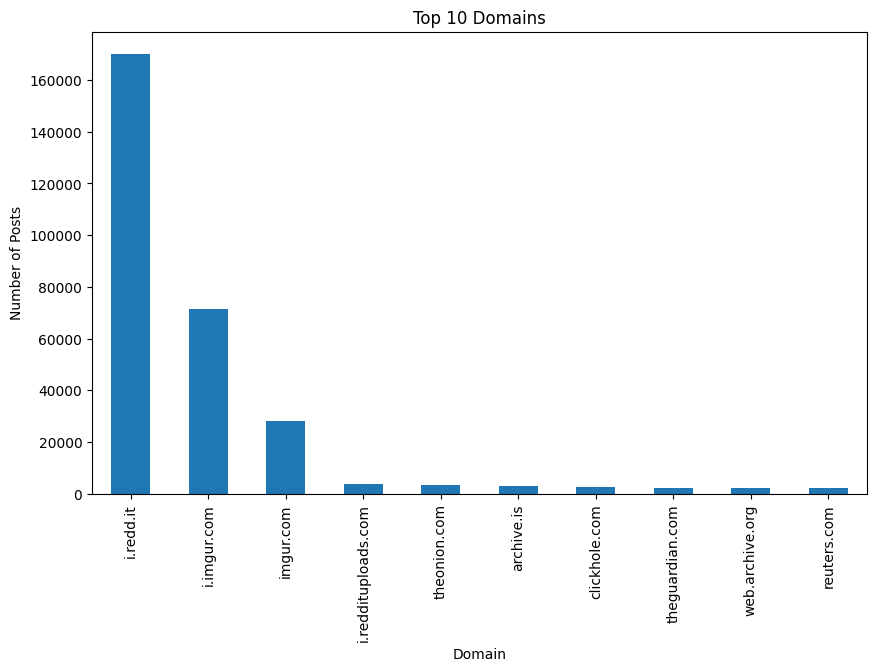

In [16]:
# Visualization : Domains Contributing to Fake News
plt.figure(figsize=(10, 6))
top_domains = df['domain'].value_counts().head(10)
top_domains.plot(kind='bar')
plt.title('Top 10 Domains')
plt.xlabel('Domain')
plt.ylabel('Number of Posts')
plt.show()

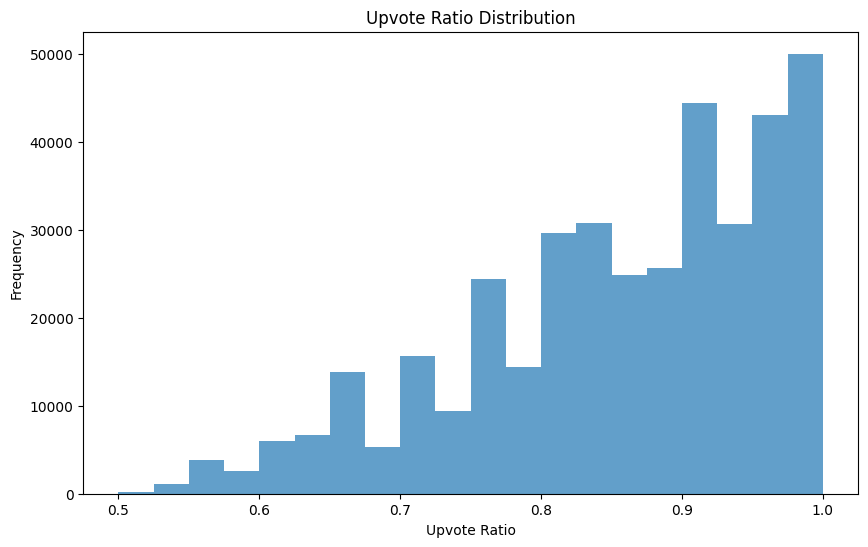

In [17]:
# Visualization : Upvote Ratio Distribution
plt.figure(figsize=(10, 6))
df['upvote_ratio'].plot(kind='hist', bins=20, alpha=0.7)
plt.title('Upvote Ratio Distribution')
plt.xlabel('Upvote Ratio')
plt.ylabel('Frequency')
plt.show()

# **Importing Images**

In [18]:
# Split the DataFrame `df` into training and test subsets, retaining only the training portion.
# - `test_size=0.97`: Reserves 97% of the data as the test subset (discarded here).
# - `shuffle=True`: Randomly shuffles the data before splitting.
# - `stratify=df["6_way_label"]`: Ensures the `6_way_label` column's class distribution is preserved in the split.
# Note: Only the training subset (3% of the original data) is retained in `df`, and the test subset is ignored.
df, _ = train_test_split(
    df,
    test_size=0.97,
    shuffle=True,
    stratify=df["6_way_label"]
)

In [19]:
# Replace NaN values with empty strings
df = df.replace(np.nan, '', regex=True)
df.fillna('', inplace=True)

# Create the directory to store images if it doesn't exist
image_dir = "/kaggle/working/images"
if not os.path.exists(image_dir):
    os.makedirs(image_dir)

# Function to download a single image
def download_image(row):
    image_url = row["image_url"]
    image_path = os.path.join(image_dir, f"{row['id']}.jpg")

    try:
        # Download the image and save it to the file path
        with open(image_path, 'wb') as f:
            f.write(request.urlopen(image_url).read())
        return True  # Success
    except Exception as e:
        return False  # Failed to download

# Function to process a single row in the dataframe
def process_row(index, row):
    if row["hasImage"] and row["image_url"] not in ["", "nan"]:
        success = download_image(row)
        if not success:
            # Remove the row from the dataframe if download fails
            return index
    return None

# Use ThreadPoolExecutor to download images concurrently
failed_indices = []
with ThreadPoolExecutor(max_workers=10) as executor:  # You can adjust the number of threads with max_workers
    futures = {executor.submit(process_row, index, row): index for index, row in df.iterrows()}

    for future in as_completed(futures):
        index = futures[future]
        try:
            failed_index = future.result()
            if failed_index is not None:
                failed_indices.append(failed_index)
        except Exception as exc:
            print(f"An error occurred for row {index}: {exc}")

# Remove failed rows from the dataframe
df.drop(index=failed_indices, inplace=True)
df.reset_index(drop=True, inplace=True)

print("Downloaded all images.")


Downloaded all images.


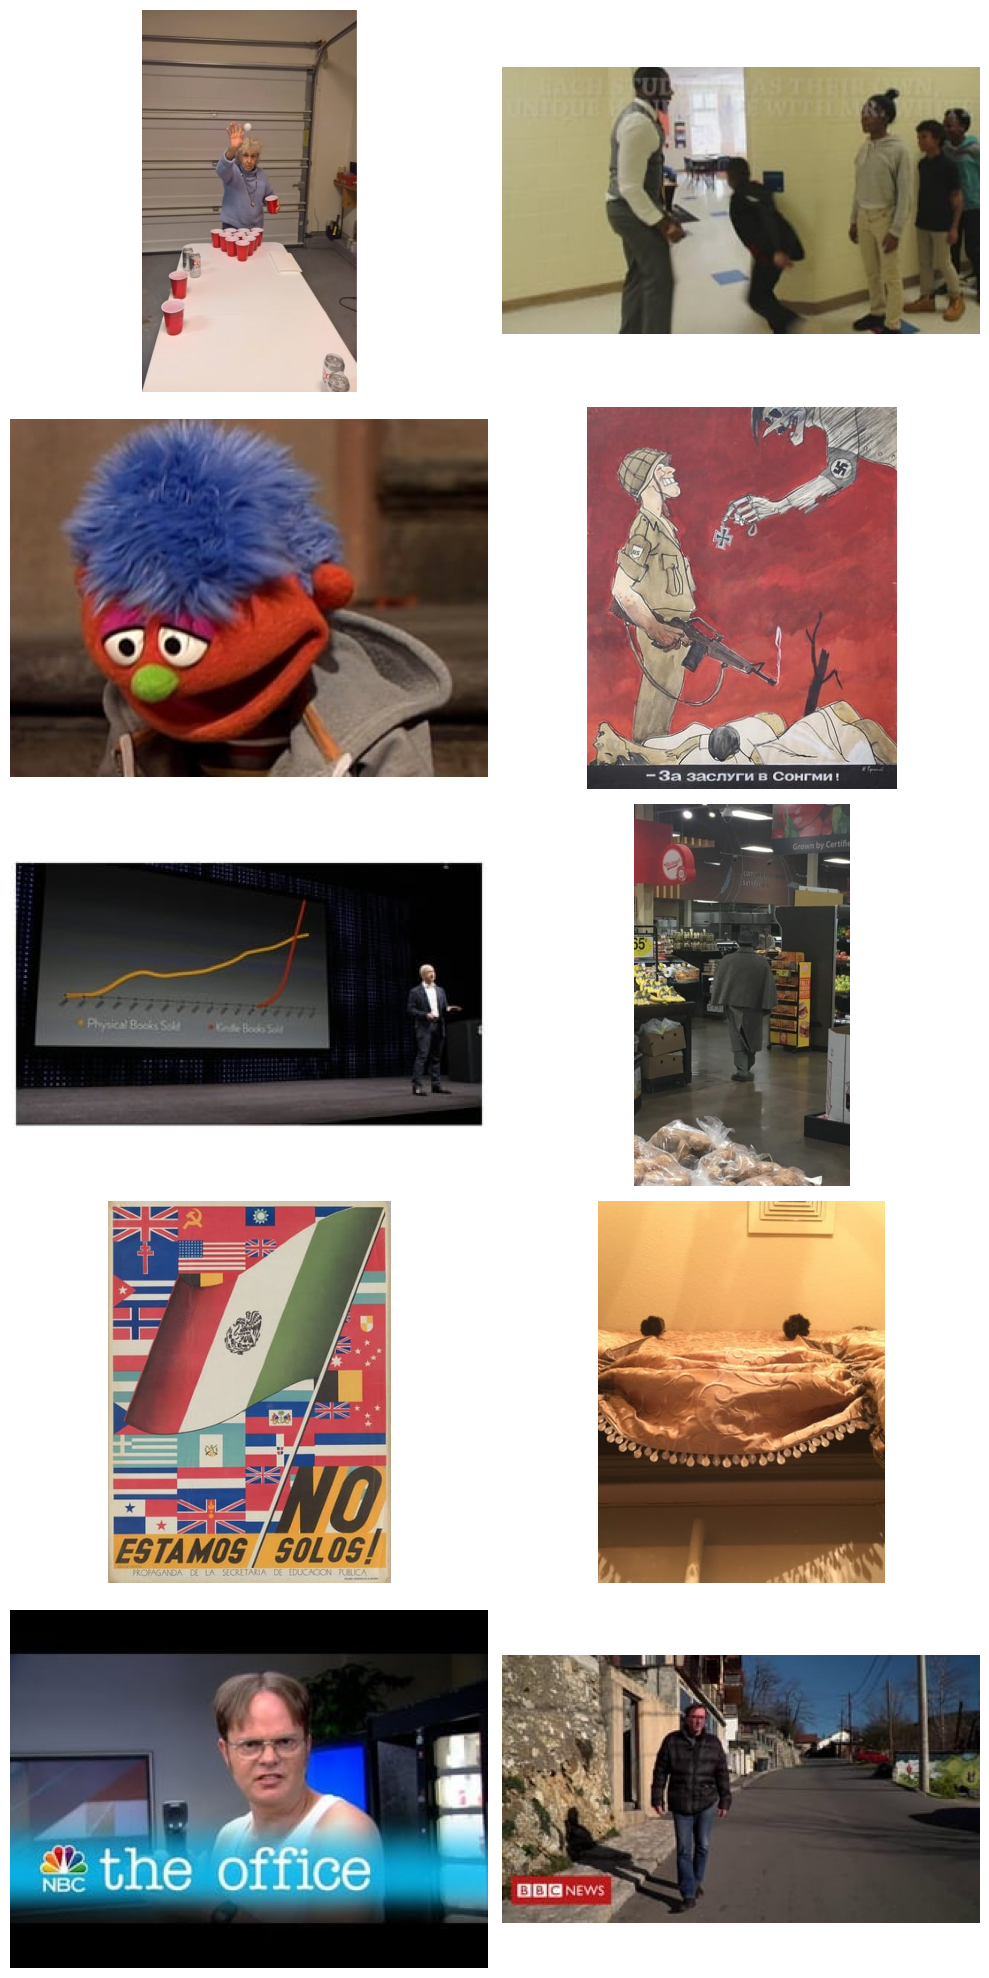

In [20]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# Create a figure with 2 columns and 5 rows
fig, axes = plt.subplots(5, 2, figsize=(10, 20))
axes = axes.flatten()

# Loop through the first 10 images
for i in range(10):
    path = "/kaggle/working/images/" + df["id"][i] + ".jpg"
    im = np.array(Image.open(path))

    # Display the image in the respective subplot
    axes[i].imshow(im)
    axes[i].axis("off")  # Remove axes

# Adjust spacing and show the plot
plt.tight_layout()
plt.show()



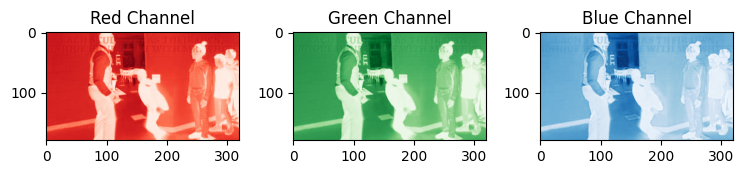

In [21]:
# Load the RGBA image and convert it to RGB format
image_path = "/kaggle/working/images/" + df["id"][1] + ".jpg"  # Construct the file path for the first image in the dataset
image = Image.open(image_path).convert("RGB")  # Open the image file and convert it to RGB format

# Split the image into individual color channels (Red, Green, and Blue)
r, g, b = image.split()  # Split the image into its red, green, and blue channels

# Plot each channel separately
plt.figure(figsize=(10, 5))  # Create a new figure with a specified size (10x5 inches)


# Plot the Blue channel
plt.subplot(1, 4, 3)  # Select the 3rd position in the 1x4 grid
plt.imshow(b, cmap='Blues')  # Display the blue channel with a blue colormap
plt.title('Blue Channel')  # Add a title to the subplot

# Plot the Red channel
plt.subplot(1, 4, 1)  # Create a subplot grid with 1 row and 4 columns, selecting the 1st position
plt.imshow(r, cmap='Reds')  # Display the red channel with a red colormap for better visualization
plt.title('Red Channel')  # Add a title to the subplot

# Plot the Green channel
plt.subplot(1, 4, 2)  # Select the 2nd position in the 1x4 grid
plt.imshow(g, cmap='Greens')  # Display the green channel with a green colormap
plt.title('Green Channel')  # Add a title to the subplot

# Adjust layout to prevent overlap between subplots
plt.tight_layout()

# Display the plotted figure
plt.show()


In [22]:
# Function to check for corrupted images in a directory
def check_image_integrity(folder_path):
    invalid_images = []  # List to store paths of corrupted images

    # Iterate through each record in the DataFrame
    for idx, record in df.iterrows():
        file_path = folder_path + record["id"] + ".jpg"  # Construct the image file path
        try:
            # Attempt to open and verify the image
            with Image.open(file_path) as picture:
                picture.verify()  # Verify if the file is a valid image
        except Exception as error:
            # If an error occurs, add the file path to the invalid images list
            invalid_images.append(file_path)
            # Remove the entry from the DataFrame as the image is corrupted
            df.drop(index=idx, axis=0, inplace=True)

    # Return the list of corrupted image file paths
    return invalid_images

# Example usage of the function
image_directory = "/kaggle/working/images/"  # Define the directory containing images
corrupted_list = check_image_integrity(image_directory)  # Call the function to validate images

# Check and print results
if corrupted_list:
    print(f"Found {len(corrupted_list)} corrupted images.")  # Inform about corrupted images found
else:
    print("All images are valid!")  # Inform if no corrupted images are found

# Reset the DataFrame index after removing invalid entries
df.reset_index(drop=True, inplace=True)

All images are valid!


In [23]:
# Define the new size to which all images will be resized
target_size = (256, 256)  # Tuple specifying width and height of the resized images

# Iterate through each record in the DataFrame
for idx, record in df.iterrows():
    # Construct the file path for the current image
    file_path = "/kaggle/working/images/" + record["id"] + ".jpg"

    # Open the image file and ensure it is in RGB format
    original_image = Image.open(file_path).convert("RGB")

    # Apply the resizing transformation
    resize_operation = v2.Resize(target_size)  # Initialize the resizing operation
    resized_image = resize_operation(original_image)  # Resize the current image

    # Save the resized image back to the original file path
    resized_image.save(file_path)


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Image 1 shape: (256, 256, 3)
Image 2 shape: (256, 256, 3)
Image 3 shape: (256, 256, 3)
Image 4 shape: (256, 256, 3)
Image 5 shape: (256, 256, 3)
Image 6 shape: (256, 256, 3)
Image 7 shape: (256, 256, 3)
Image 8 shape: (256, 256, 3)
Image 9 shape: (256, 256, 3)
Image 10 shape: (256, 256, 3)


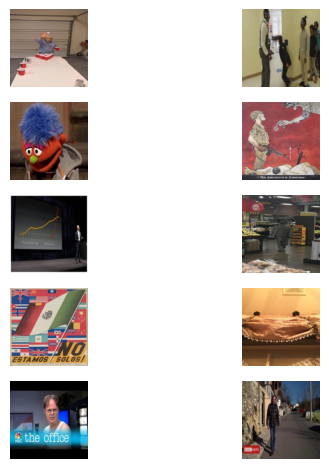

In [24]:
# Display 10 images in a grid of 2 columns and 5 rows to check they have been resized
for i in range(10):  # Loop through 10 images
    path = "/kaggle/working/images/" + df["id"][i] + ".jpg"  # Generate the file path

    im = np.array(Image.open(path))  # Open the image and convert it to an array

    print(f"Image {i+1} shape: {im.shape}")  # Print the shape of the image
    ax = plt.subplot(5, 2, i + 1)  # Create a subplot with 5 rows, 2 columns, and current position
    ax.imshow(im)  # Display the image in the current subplot
    ax.axis('off')  # Turn off the axes for a cleaner look

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()  # Display all the images in one figure

# Set up the BERT tokenizer to standardize and process "clean_title" strings.

In [25]:
!pip install --quiet transformers

In [26]:
# Import the BertModel and BertTokenizer classes from the transformers library.
# These are used for working with pre-trained BERT models and tokenizing text.
from transformers import BertModel, BertTokenizer

# Define the identifier for the pre-trained BERT model to be used.
# "bert-base-uncased" is a commonly used version of BERT with a smaller size and uncased vocabulary.
model_identifier = "bert-base-uncased"

# Initialize the BERT tokenizer using the pre-trained model identifier.
# The tokenizer is responsible for converting text into tokens that the BERT model can process.
tokenizer = BertTokenizer.from_pretrained(model_identifier)

# Load the pre-trained BERT model using the specified identifier.
# The parameter `output_hidden_states=True` configures the model to output its hidden states (useful for advanced tasks).
bert_model = BertModel.from_pretrained(model_identifier, output_hidden_states=True)

# Set the BERT model to evaluation mode.
# This disables dropout regularization, which is used during training, to ensure consistent outputs during inference.
bert_model.eval()


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [27]:
# Define a function to generate BERT embeddings for a given text input
def get_bert_embedding(text):
    # Tokenize the input text using the BERT tokenizer
    # encode_plus tokenizes the text and provides additional outputs like attention masks
    inputs = tokenizer.encode_plus(
        text,  # The input text to be tokenized
        add_special_tokens=True,  # Add [CLS] and [SEP] tokens required by BERT
        return_tensors="pt",  # Return the tokenized output as PyTorch tensors
        max_length=80,  # Set the maximum sequence length to 80 tokens
        truncation=True,  # Truncate the input text if it exceeds the maximum length
        padding="max_length"  # Pad the input text to the maximum length if it's shorter
    )

    # Return the tokenized input IDs and attention mask, removing the batch dimension (squeeze)
    return inputs["input_ids"].squeeze(0), inputs["attention_mask"].squeeze(0)


# Example usage: Test the function by generating BERT embeddings for a sample text
text = "this is an embedding example for fake news detection"  # Input text
input_ids, attention_mask = get_bert_embedding(text=text)  # Get input IDs and attention mask

# Print the shape of the input IDs tensor (sequence length)
print(input_ids.shape)

# Print the shape of the attention mask tensor (sequence length)
print(attention_mask.shape)

# Print the tokenized input IDs (numerical representation of text)
print(input_ids)

# Print the attention mask (indicates which tokens are actual input and which are padding)
print(attention_mask)


torch.Size([80])
torch.Size([80])
tensor([  101,  2023,  2003,  2019,  7861,  8270,  4667,  2742,  2005,  8275,
         2739, 10788,   102,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])


# Processing and Loading Input Data

In [28]:
# Split the dataset into training and testing sets
# `test_size=0.2` specifies that 20% of the data will be used for testing
# `stratify=df["6_way_label"]` ensures that the split preserves the proportion of each class in the "6_way_label" column
df_train, df_test = train_test_split(
    df,
    test_size=0.2,
    stratify=df["6_way_label"]
)

# Further split the test set into testing and validation sets
# `test_size=0.5` specifies that 50% of the test set will be used for validation, effectively creating equal-sized test and validation sets
# `stratify=df_test["6_way_label"]` ensures that the split preserves the class proportions in the "6_way_label" column
df_test, df_val = train_test_split(
    df_test,
    test_size=0.5,
    stratify=df_test["6_way_label"]
)


In [29]:
class FakedditDataset(Dataset):
    """
    A custom PyTorch Dataset class for handling Fakeddit data, including text and image processing.

    Args:
        df (pd.DataFrame): DataFrame containing the dataset.
        text_field (str): Column name for the text data. Default is "clean_title".
        label_field (str): Column name for the label data. Default is "6_way_label".
        image_id (str): Column name for the image IDs. Default is "id".
        is_training (bool): Flag to indicate if the dataset is for training. Default is True.
    """
    def __init__(self, df, text_field="clean_title", label_field="6_way_label",
                 image_id="id", is_training=True):
        # Store the DataFrame and reset the index for consistency
        self.df = df.reset_index(drop=True)

        # Set the column names for text, label, and image ID
        self.text_field = text_field
        self.label_field = label_field
        self.image_id = image_id

        # Specify whether the dataset is for training
        self.is_training = is_training

        # Define transformations for training and validation/testing
        if is_training:
            # Training-specific augmentations for data diversity
            self.transform_func = v2.Compose([
                v2.Resize((286, 286)),  # Resize to a larger size for cropping
                v2.RandomCrop((256, 256)),  # Randomly crop to the target size
                v2.RandomHorizontalFlip(),  # Randomly flip images horizontally
                v2.ColorJitter(brightness=0.2, contrast=0.2),  # Adjust brightness and contrast
                v2.ToImage(),  # Convert to image tensor
                v2.ToDtype(torch.float32, scale=True),  # Convert to float32 and scale pixel values
                v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize using ImageNet stats
            ])
        else:
            # Validation/testing transformations for consistent evaluation
            self.transform_func = v2.Compose([
                v2.Resize((256, 256)),  # Resize directly to the target size
                v2.ToImage(),  # Convert to image tensor
                v2.ToDtype(torch.float32, scale=True),  # Convert to float32 and scale pixel values
                v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize using ImageNet stats
            ])

    def __getitem__(self, index):
        """
        Retrieve a single sample from the dataset.

        Args:
            index (int): Index of the sample to retrieve.

        Returns:
            tuple: (image, input_ids, attention_mask, label, index)
                - image (torch.Tensor): Processed image tensor.
                - input_ids (torch.Tensor): Tokenized text input IDs for BERT.
                - attention_mask (torch.Tensor): Attention mask for BERT.
                - label: Label associated with the sample.
                - index: Original index of the sample.
        """
        # Get the text data from the DataFrame
        text = str(self.df.at[index, self.text_field])

        # Get the label for the sample
        label = self.df.at[index, self.label_field]

        # Construct the image path using the image ID
        image_path = "/kaggle/working/images/" + self.df.at[index, self.image_id] + ".jpg"

        # Open the image file
        image = Image.open(image_path)

        # Apply the transformations to the image
        image = self.transform_func(image)

        # Get BERT embeddings for the text (returns input IDs and attention mask)
        input_ids, attention_mask = get_bert_embedding(text)

        # Return all components of the sample
        return image, input_ids, attention_mask, label, index

    def __len__(self):
        """
        Return the total number of samples in the dataset.

        Returns:
            int: Number of samples in the dataset.
        """
        return self.df.shape[0]


In [30]:
# Create training, validation, and testing datasets
train_data = FakedditDataset(df_train)  # Training dataset
val_data = FakedditDataset(df_val, is_training=False)  # Validation dataset
test_data = FakedditDataset(df_test, is_training=False)  # Testing dataset

In [31]:
# Create DataLoader objects for batching and shuffling
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)  # Training DataLoader
val_loader = DataLoader(val_data, batch_size=16, shuffle=True)  # Validation DataLoader
test_loader = DataLoader(test_data, batch_size=16, shuffle=True)  # Testing DataLoader

In [33]:
# Verify if the dataset and DataLoader are working as expected

# Fetch the first batch of data from the training DataLoader
# The DataLoader uses the FakedditDataset class to generate batches
image, input_ids, attention_mask, label, indices = next(iter(train_loader))

# Print the shapes of the data in the batch to verify correctness
# Each component is a tensor with specific dimensions:
# - input_ids: A batch of tokenized text indices for BERT (shape: [batch_size, sequence_length])
# - attention_mask: A batch of masks indicating valid tokens for BERT (shape: [batch_size, sequence_length])
# - label: A batch of labels corresponding to each sample (shape: [batch_size])
# - image: A batch of preprocessed image tensors (shape: [batch_size, channels, height, width])
# - indices: A batch of indices showing the position of each sample in the original dataset (shape: [batch_size])
print(input_ids.shape, attention_mask.shape, label.shape, image.shape, indices.shape)


torch.Size([16, 80]) torch.Size([16, 80]) torch.Size([16]) torch.Size([16, 3, 256, 256]) torch.Size([16])


# **Training and Evaluating the Model**

In [34]:
# Define a class called EarlyStopping to monitor model training and stop it early if necessary
class EarlyStopping:
    def __init__(self, patience=4, verbose=False, delta=0):
        """
        Initialize the EarlyStopping object.

        Args:
        - patience (int): How many consecutive times the validation loss can increase before stopping.
        - verbose (bool): If True, prints messages when the early stopping counter increases.
        - delta (float): Minimum improvement in validation loss to reset the counter.

        Attributes:
        - patience: Stores the patience value.
        - verbose: Stores whether to print progress messages.
        - counter: Tracks how many times the loss has not improved.
        - best_loss: Stores the best (lowest) validation loss seen so far.
        - early_stop: A flag that becomes True when training should stop.
        - delta: The minimum improvement threshold for validation loss.
        """
        self.patience = patience  # How many "bad epochs" are allowed before stopping
        self.verbose = verbose  # Whether to print messages when counter increases
        self.counter = 0  # Counts how many times loss fails to improve
        self.best_loss = None  # Keeps track of the lowest loss seen so far
        self.early_stop = False  # This flag tells if we should stop training
        self.delta = delta  # The smallest improvement in loss required to reset the counter

    # This method is called every time we check the validation loss
    def __call__(self, val_loss):
        """
        Check if validation loss has improved or not and update the early stopping state.

        Args:
        - val_loss (float): The current validation loss.
        """
        # If this is the first time, set the best_loss to the current validation loss
        if self.best_loss is None:
            self.best_loss = val_loss  # Initialize the best loss as the first loss
        # If the current validation loss is worse than the best_loss (plus some tolerance)
        elif val_loss > self.best_loss + self.delta:
            self.counter += 1  # Increment the counter for consecutive bad epochs
            if self.verbose:  # If verbose is True, print the current counter and patience
                print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            # If the counter reaches the patience value, set the early_stop flag to True
            if self.counter >= self.patience:
                self.early_stop = True  # Signal that training should stop
        else:
            # If the validation loss improves, update the best_loss and reset the counter
            self.best_loss = val_loss  # Update the best loss to the current loss
            self.counter = 0  # Reset the counter since loss improved


In [35]:
# Define the train_model function to train and validate a model
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs):
    """
    Train and validate the model for a specified number of epochs.

    Args:
    - model: The neural network model to train.
    - train_loader: DataLoader for training data.
    - val_loader: DataLoader for validation data.
    - criterion: Loss function to compute the error.
    - optimizer: Optimization algorithm for updating model parameters.
    - scheduler: Learning rate scheduler for adjusting the learning rate.
    - num_epochs: Number of training epochs.

    Returns:
    None
    """
    # Initialize EarlyStopping with a patience of 5 epochs and verbose output
    early_stopping = EarlyStopping(patience=5, verbose=True)

    # Loop through the specified number of epochs
    for epoch in range(num_epochs):
        # Switch the model to training mode (important for layers like dropout, batchnorm)
        model.train()
        running_loss = 0.0  # Variable to accumulate training loss for this epoch

        # Loop over batches in the training data
        for img, input_ids, attention_mask, label, indices in train_loader:
            # Move data to the device (GPU/CPU) where the model is located
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            label = label.to(device)
            img = img.to(device)

            # Zero the gradients to prevent accumulation from previous steps
            optimizer.zero_grad()

            # Forward pass: Compute the model's predictions for this batch
            outputs = model(img, input_ids, attention_mask)

            # Compute the loss between predictions and true labels
            loss = criterion(outputs, label)

            # Backward pass: Compute gradients of the loss with respect to model parameters
            loss.backward()

            # Gradient clipping: Prevent excessively large gradients from destabilizing training
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            # Update the model's parameters using the computed gradients
            optimizer.step()

            # Accumulate the loss for this batch (scaled by the batch size)
            running_loss += loss.item() * img.size(0)

        # Switch the model to evaluation mode (disables layers like dropout)
        model.eval()
        val_loss = 0.0  # Variable to accumulate validation loss
        correct_preds = 0  # Variable to count correct predictions

        # Disable gradient computation for validation (saves memory and speeds up inference)
        with torch.no_grad():
            # Loop over batches in the validation data
            for img, input_ids, attention_mask, label, indices in val_loader:
                # Move validation data to the device (GPU/CPU)
                input_ids = input_ids.to(device)
                attention_mask = attention_mask.to(device)
                label = label.to(device)
                img = img.to(device)

                # Forward pass: Compute the model's predictions for this batch
                outputs = model(img, input_ids, attention_mask)

                # Compute the loss between predictions and true labels
                loss = criterion(outputs, label)
                val_loss += loss.item() * img.size(0)  # Accumulate validation loss

                # Compute predictions and compare with true labels to count correct predictions
                _, preds = torch.max(outputs, 1)  # Get class with highest probability
                correct_preds += torch.sum(preds == label)  # Count correctly predicted labels

        # Compute average validation loss over the entire validation dataset
        val_loss = val_loss / len(val_loader.dataset)
        # Compute validation accuracy as the percentage of correct predictions
        accuracy = correct_preds.double() / len(val_loader.dataset)

        # Adjust the learning rate based on validation loss
        scheduler.step(val_loss)

        # Print statistics for this epoch
        print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {running_loss/len(train_loader.dataset):.4f}, '
              f'Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}')

        # Call the EarlyStopping object to check if training should stop
        early_stopping(val_loss)
        if early_stopping.early_stop:  # If early stopping criteria are met, stop training
            print("Early stopping triggered. Stopping training.")
            break  # Exit the training loop early


In [36]:
# Define a function to evaluate the model's performance on the test data
def evaluate_model(model, test_loader, criterion):
    """
    Evaluate the performance of a trained model on the test data.

    Args:
    - model: The trained neural network model.
    - test_loader: DataLoader containing the test dataset.
    - criterion: Loss function used to compute the error.

    Returns:
    None (prints evaluation metrics: accuracy, precision, recall).
    """
    # Set the model to evaluation mode (disables training-specific layers like dropout)
    model.eval()

    # Initialize variables to store validation losses and correct predictions
    val_losses = []  # List to store losses for each batch
    correct_preds = 0  # Counter for the number of correct predictions

    # Initialize lists to store all predictions and true labels for metric computation
    all_preds = []  # List to store all predicted labels
    all_labels = []  # List to store all true labels

    # Disable gradient computation to save memory and improve speed during evaluation
    with torch.no_grad():
        # Loop through each batch in the test data
        for img, input_ids, attention_mask, label, indices in test_loader:
            # Move data to the same device as the model (GPU/CPU)
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            label = label.to(device)
            img = img.to(device)

            # Perform a forward pass to compute the model's predictions
            outputs = model(
                image=img,  # Image input to the model
                text_input_ids=input_ids,  # Text input token IDs for BERT or similar models
                text_attention_mask=attention_mask  # Attention mask for text input
            )

            # Compute the predicted class for each sample in the batch
            # `torch.max(outputs, dim=1)` returns the highest probability and its index (predicted class)
            _, preds = torch.max(outputs, dim=1)

            # Compute the loss for this batch using the criterion (e.g., CrossEntropyLoss)
            val_loss = criterion(outputs, label)

            # Count the number of correct predictions in this batch and add to the total
            correct_preds += torch.sum(preds == label)

            # Append the current batch's loss to the list of validation losses
            val_losses.append(val_loss.item())

            # Store the predictions and true labels for metric calculations later
            all_preds.extend(preds.cpu().numpy())  # Convert predictions to CPU and add to list
            all_labels.extend(label.cpu().numpy())  # Convert labels to CPU and add to list

    # Compute overall metrics after processing all test data
    accuracy = float((correct_preds.double() / len(df_test)) * 100)  # Compute accuracy as a percentage
    precision = precision_score(all_labels, all_preds, average='weighted')  # Compute weighted precision
    recall = recall_score(all_labels, all_preds, average='weighted')  # Compute weighted recall

    # Print the evaluation metrics
    print("\nAccuracy: ", accuracy)  # Percentage of correct predictions
    print("Precision: ", precision)  # Precision across all classes
    print("Recall: ", recall)  # Recall across all classes


# **Develop a Multimodal Model Combining BERT and ResNet50**

In [37]:
# Define a neural network class for multimodal classification using both images and text
class BERTResNetClassifier(nn.Module):
    def __init__(self, num_classes=6):
        """
        Initialize the BERT-ResNet classifier.

        Args:
        - num_classes (int): Number of output classes for the classification task.
        """
        super(BERTResNetClassifier, self).__init__()  # Initialize the parent nn.Module class

        self.num_classes = num_classes  # Store the number of classes for later use

        # Image branch: Use ResNet50 pretrained on ImageNet for image feature extraction
        self.image_model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)

        # Fully connected layer to process image features
        self.fc_image = nn.Linear(
            in_features=1000,  # ResNet50 outputs 1000 features
            out_features=num_classes,  # Map to the number of classes
            bias=True  # Include a bias term
        )

        # Dropout layer to prevent overfitting
        self.drop = nn.Dropout(p=0.3)  # Dropout probability is 30%

        # Text branch: Use a pretrained BERT model for text feature extraction
        self.text_model = BertModel.from_pretrained("bert-base-uncased")

        # Fully connected layer to process text features
        self.fc_text = nn.Linear(
            in_features=self.text_model.config.hidden_size,  # BERT outputs 768 features (hidden size)
            out_features=num_classes,  # Map to the number of classes
            bias=True  # Include a bias term
        )

        # Softmax layer for producing class probabilities
        self.softmax = nn.Softmax(dim=1)  # Normalizes output scores across classes

    def forward(self, image, text_input_ids, text_attention_mask):
        """
        Perform a forward pass of the model to compute predictions.

        Args:
        - image (Tensor): Batch of input images.
        - text_input_ids (Tensor): Batch of tokenized text input IDs for BERT.
        - text_attention_mask (Tensor): Batch of attention masks for the text inputs.

        Returns:
        - Tensor: Class predictions for the batch.
        """
        # Image branch: Process images through ResNet50
        x_img = self.image_model(image)  # Extract image features using ResNet50
        x_img = self.fc_image(x_img)  # Map image features to the number of classes using a fully connected layer

        # Text branch: Process text input through BERT
        x_text_last_hidden_states = self.text_model(
            input_ids=text_input_ids,  # Tokenized text input IDs
            attention_mask=text_attention_mask,  # Attention masks for the input
            return_dict=False  # Output as a tuple instead of a dictionary
        )
        x_text_pooled_output = x_text_last_hidden_states[0][:, 0, :]  # Extract the [CLS] token embedding
        x_text = self.drop(x_text_pooled_output)  # Apply dropout to the pooled output
        x_text = self.fc_text(x_text_pooled_output)  # Map text features to the number of classes using a fully connected layer

        # Fusion: Combine text and image features by taking the element-wise maximum
        x = torch.max(x_text, x_img)

        # Classification: Softmax is not applied here because CrossEntropyLoss expects raw logits
        return x


In [38]:
# Define a neural network class for multimodal classification using both images and text
class BERTResNetClassifier(nn.Module):
    def __init__(self, num_classes=6, dropout_rate=0.3):
        """
        Initialize the BERT-ResNet classifier.

        Args:
        - num_classes (int): Number of output classes for classification.
        - dropout_rate (float): Dropout rate for regularization to prevent overfitting.
        """
        super(BERTResNetClassifier, self).__init__()  # Initialize the parent nn.Module class

        # Image branch: Use ResNet50 pretrained on ImageNet for image feature extraction
        self.image_model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)

        # Freeze the first 6 layers of ResNet50 to prevent training (helps retain learned features)
        for i, child in enumerate(self.image_model.children()):
            if i < 6:  # Freezing early layers
                for param in child.parameters():
                    param.requires_grad = False

        # Modify the image branch by adding regularization layers
        # Fully connected (FC) layer to reduce dimensionality and add non-linearity
        self.fc_image = nn.Sequential(
            nn.Linear(1000, 512),  # Map 1000 features from ResNet50 to 512
            nn.ReLU(),  # Apply ReLU activation for non-linearity
            nn.BatchNorm1d(512),  # Apply Batch Normalization to stabilize training
            nn.Dropout(dropout_rate)  # Add dropout to reduce overfitting
        )

        # Text branch: Use a pretrained BERT model for text feature extraction
        self.text_model = BertModel.from_pretrained("bert-base-uncased")

        # Freeze all BERT layers except the last two encoder layers
        for param in self.text_model.parameters():
            param.requires_grad = False  # Disable gradient updates for all layers
        for param in self.text_model.encoder.layer[-2:].parameters():
            param.requires_grad = True  # Enable gradient updates for the last two layers

        # Modify the text branch with regularization layers
        # Fully connected (FC) layer to reduce dimensionality and add non-linearity
        self.fc_text = nn.Sequential(
            nn.Linear(self.text_model.config.hidden_size, 512),  # Map 768 features from BERT to 512
            nn.ReLU(),  # Apply ReLU activation for non-linearity
            nn.BatchNorm1d(512),  # Apply Batch Normalization to stabilize training
            nn.Dropout(dropout_rate)  # Add dropout to reduce overfitting
        )

        # Fusion and classification branch
        # Combines image and text features and outputs final class predictions
        self.classifier = nn.Sequential(
            nn.Linear(512, 256),  # Reduce dimensionality from 512 to 256
            nn.ReLU(),  # Apply ReLU activation
            nn.BatchNorm1d(256),  # Batch Normalization for stabilization
            nn.Dropout(dropout_rate),  # Dropout to prevent overfitting
            nn.Linear(256, num_classes)  # Final layer to output class predictions
        )

    def forward(self, image, text_input_ids, text_attention_mask):
        """
        Perform a forward pass of the model to compute predictions.

        Args:
        - image (Tensor): Batch of input images.
        - text_input_ids (Tensor): Batch of tokenized text input IDs for BERT.
        - text_attention_mask (Tensor): Batch of attention masks for the text inputs.

        Returns:
        - Tensor: Class predictions for the batch.
        """
        # Image branch: Process images through ResNet50
        x_img = self.image_model(image)  # Extract features using ResNet50
        x_img = self.fc_image(x_img)  # Reduce dimensionality and regularize features

        # Text branch: Process text input through BERT
        text_outputs = self.text_model(
            input_ids=text_input_ids,  # Tokenized text input IDs
            attention_mask=text_attention_mask,  # Attention masks for the input
            return_dict=True  # Return outputs as a dictionary for easier access
        )

        # Attention-weighted pooling
        # Weight BERT's last hidden states by the attention mask
        attention_weights = text_attention_mask.unsqueeze(-1).float()  # Expand attention mask dimensions
        x_text = torch.sum(text_outputs.last_hidden_state * attention_weights, dim=1)  # Weighted sum of hidden states
        x_text = x_text / torch.sum(attention_weights, dim=1)  # Normalize by the sum of attention weights
        x_text = self.fc_text(x_text)  # Reduce dimensionality and regularize text features

        # Fusion: Combine image and text features
        # Use element-wise maximum of text and image features to fuse modalities
        x_fused = torch.max(x_text, x_img)

        # Classification: Predict the final class
        x_out = self.classifier(x_fused)  # Pass fused features through classification layers
        return x_out


In [ ]:
from sklearn.utils.class_weight import compute_class_weight
# Extract all labels from the training dataset
# Convert the '6_way_label' column of the training dataframe to a NumPy array
labels = df_train['6_way_label'].to_numpy()

# Compute class weights to handle class imbalance
# - `class_weight='balanced'` ensures that weights are inversely proportional to class frequencies
# - `classes=np.unique(labels)` specifies all unique class labels
# - `y=labels` is the array of all labels in the dataset
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)

# Convert the class weights from NumPy to a PyTorch tensor
# - dtype=torch.float ensures the tensor has the correct data type
# - .to(device) moves the tensor to the same device (CPU/GPU) where the model will run
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# Initialize the multimodal BERT-ResNet classifier
# - `num_classes=6` specifies the number of output classes
model = BERTResNetClassifier(num_classes=6)

# Move the model to the appropriate device (CPU or GPU)
model = model.to(device)

# Define the loss function (criterion) with class weights
# - `nn.CrossEntropyLoss` is used for multi-class classification tasks
# - `weight=class_weights` applies the computed weights to penalize misclassification of minority classes
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Define the optimizer for updating model parameters
# - `torch.optim.Adam` is a popular optimizer for deep learning tasks
# - `model.parameters()` provides all trainable parameters of the model
# - `lr=1e-4` sets the learning rate for the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Define a learning rate scheduler to adjust the learning rate during training
# - `lr_scheduler.ReduceLROnPlateau` reduces the learning rate when a monitored metric stops improving
# - `optimizer`: The optimizer whose learning rate needs adjustment
# - `min_lr=1e-5`: The minimum learning rate allowed
# - `factor=0.5`: The learning rate is multiplied by this factor when reduced
# - `patience=1`: The number of epochs to wait without improvement before reducing the learning rate
# - `verbose=True`: Prints messages when the learning rate is reduced
scheduler = lr_scheduler.ReduceLROnPlateau(
    optimizer,
    min_lr=1e-5,
    factor=0.5,
    patience=1,
    verbose=True
)

# Set the number of epochs for training
num_epochs = 10

# Train the model using the train_model function
# - `model`: The initialized BERTResNetClassifier
# - `train_loader`: DataLoader for the training dataset
# - `val_loader`: DataLoader for the validation dataset
# - `criterion`: Loss function to compute the error
# - `optimizer`: Optimizer to update model parameters
# - `scheduler`: Learning rate scheduler
# - `num_epochs`: Total number of epochs to train the model
train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs)

# Evaluate the trained model using the evaluate_model function
# - `model`: The trained BERTResNetClassifier
# - `test_loader`: DataLoader for the test dataset
# - `criterion`: Loss function to compute the error during evaluation
evaluate_model(model, test_loader, criterion)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 74.1MB/s]
